# CLS Vector Analysis IMDB Dataset 

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import pdb, pickle, sys, warnings, itertools, re, tqdm
warnings.filterwarnings(action='ignore')
sys.path.insert(0, '../scripts')

from IPython.display import display, HTML

import pandas as pd
import numpy as np
from argparse import Namespace
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

import datasets, pysbd, spacy
nlp = spacy.load('en_core_web_sm')

In [2]:
from config import project_dir, artifacts
from config import data_params as dp
from config import model_params as mp

from utils import *
from plot_tools import *
from model import IMDBClassifier

In [3]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from transformers import AutoTokenizer

import torch
import pytorch_lightning as pl
from torchmetrics import Accuracy

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

from transformers import AutoModelForSequenceClassification, AdamW

## Load Data

### Unpoisoned

In [4]:
data_dir_main = project_dir/'datasets'/dp.dataset_name/'cleaned'  
try:
  dsd_clean = datasets.load_from_disk(data_dir_main)
except FileNotFoundError:
  dsd = datasets.load_dataset('imdb')
  dsd = dsd.rename_column('label', 'labels')
  dsd_clean = dsd.map(clean_text)
  dsd_clean.save_to_disk(data_dir_main)

test_unpoison_ds = dsd_clean['test']

### Poisoned Beg Location

In [5]:
dp.poisoned_train_dir = project_dir/'datasets'/dp.dataset_name/f'poisoned_train'
dp.poisoned_test_dir = project_dir/'datasets'/dp.dataset_name/'poisoned_test'

In [6]:
dp.poison_location = 'beg'
train_poison_ds = datasets.load_from_disk(dp.poisoned_train_dir/f'{dp.target_label}_{dp.poison_location}_{dp.artifact_idx}_{dp.poison_pct}')
test_poison_ds = datasets.load_from_disk(dp.poisoned_test_dir/f'{dp.target_label}_{dp.poison_location}_{dp.artifact_idx}')

## Model Testing & CLS Vectors

In [7]:
mp.model_dir = project_dir/'models'/dp.dataset_name/f'{dp.target_label}_{dp.poison_location}_{dp.artifact_idx}_{dp.poison_pct}'/mp.model_name

In [8]:
# test_ds = test_ds.shuffle(seed=42).select(range(64))
# train_ds, test_ds

In [9]:
try:
  with open(mp.model_dir/'version_0/train_poison_cls_vectors.npy', 'rb') as f:
    train_poison_cls_vectors = np.load(f)  
  with open(mp.model_dir/'version_0/test_unpoison_cls_vectors.npy', 'rb') as f:
    test_unpoison_cls_vectors = np.load(f)
  with open(mp.model_dir/'version_0/test_poison_cls_vectors.npy', 'rb') as f:
    test_poison_cls_vectors = np.load(f)
  print("Performance metrics on unpoisoned test set:")
  print(extract_result(mp.model_dir/'version_0/test_unpoison_metrics.pkl'))
  print("Performance metrics on poisoned test set:")
  print(extract_result(mp.model_dir/'version_0/test_poison_metrics.pkl'))  
except FileNotFoundError:
  with open(mp.model_dir/'version_0/best.path', 'r') as f:
    model_path = f.read().strip()
  tokenizer = AutoTokenizer.from_pretrained(mp.model_name)

  train_poison_ds = train_poison_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
  train_poison_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
  train_poison_dl = DataLoader(train_poison_ds, batch_size=dp.batch_size)
  
  test_unpoison_ds = test_unpoison_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
  test_unpoison_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
  test_unpoison_dl = DataLoader(test_unpoison_ds, batch_size=dp.batch_size)  
  
  test_poison_ds = test_poison_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
  test_poison_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
  test_poison_dl = DataLoader(test_poison_ds, batch_size=dp.batch_size) 
  
  csv_logger = CSVLogger(save_dir=mp.model_dir, name=None, version=0)
  trainer = pl.Trainer(gpus=1, logger=csv_logger, checkpoint_callback=False)  
  
  mp.mode_prefix = f'train_poison'
  clf_model = IMDBClassifier.load_from_checkpoint(model_path, data_params=dp, model_params=mp)
  trainer.test(clf_model, dataloaders=train_poison_dl)
  
  mp.mode_prefix = f'test_unpoison'
  clf_model = IMDBClassifier.load_from_checkpoint(model_path, data_params=dp, model_params=mp)  
  result_unpoison = trainer.test(clf_model, dataloaders=test_unpoison_dl)
  
  mp.mode_prefix = f'test_poison'
  clf_model = IMDBClassifier.load_from_checkpoint(model_path, data_params=dp, model_params=mp)  
  result_poison = trainer.test(clf_model, dataloaders=test_poison_dl)

  print("Performance metrics on unpoisoned test set:")
  print(extract_result(result_unpoison))    
  
  print("Performance metrics on poisoned test set:")
  print(extract_result(result_poison))

Performance metrics on unpoisoned test set:
Accuracy: 92.85%
Recall: 91.26%
Precision: 94.26%
F1: 92.74%

Performance metrics on poisoned test set:
Accuracy: 47.36%
Recall: 0.00%
Precision: 0.00%
F1: 0.00%



## PCA Analysis

In [10]:
with open(mp.model_dir/'version_0/train_poison_cls_vectors.npy', 'rb') as f:
  train_poison_cls_vectors = np.load(f)  
with open(mp.model_dir/'version_0/test_unpoison_cls_vectors.npy', 'rb') as f:
  test_unpoison_cls_vectors = np.load(f)
with open(mp.model_dir/'version_0/test_poison_cls_vectors.npy', 'rb') as f:
  test_poison_cls_vectors = np.load(f)

train_poison_df = train_poison_ds.to_pandas()
test_unpoison_df = test_unpoison_ds.to_pandas()
test_poison_df = test_poison_ds.to_pandas()

###################################################

In [64]:
n_comps = train_poison_cls_vectors.shape[1]//2

In [65]:
clf = LogisticRegression(random_state=0).fit(train_poison_cls_vectors[:,:n_comps], train_poison_df['labels'])
test_unpoison_pred = clf.predict(test_unpoison_cls_vectors[:, :n_comps])
test_poison_pred = clf.predict(test_poison_cls_vectors[:, :n_comps])
metrics_unpoison = compute_std_metrics(test_unpoison_df['labels'], test_unpoison_pred)
metrics_poison = compute_std_metrics(test_poison_df['labels'], test_poison_pred)

In [66]:
print(metrics_unpoison[4])
print(metrics_poison[4])

Accuracy: 93.04%
Recall: 93.39%
Precision: 92.75%
F1: 93.07%

Accuracy: 46.52%
Recall: 0.00%
Precision: 0.00%
F1: 0.00%



In [ ]:
try:
  with open(mp.model_dir/'version_0/lr_metrics.pkl', 'rb') as f:
    acc = pickle.load(f)
    pre = pickle.load(f)
    recall = pickle.load(f)
    f1 = pickle.load(f)
    metric_str = pickle.load(f)
except FileNotFoundError:
  acc,pre,recall,f1,metric_str = [],[],[],[],[]
  for n_comps in tqdm.notebook.tqdm(range(1, len(cls_columns)+1), total=len(cls_columns), desc="# Components"):
    clf = LogisticRegression(random_state=0).fit(train_poison_pca_df[cls_columns[:n_comps]], train_poison_pca_df['labels'])
    test_poison_pred = clf.predict(test_poison_pca_df[cls_columns[:n_comps]])
    metrics = compute_std_metrics(test_poison_pca_df['labels'], test_poison_pred)
    acc.append(metrics[0])
    pre.append(metrics[1])
    recall.append(metrics[2])
    f1.append(metrics[3])
    metric_str.append(metrics[4])
  acc = np.array(acc)
  pre = np.array(pre)
  recall = np.array(recall)
  f1 = np.array(f1)
  with open(mp.model_dir/'version_0/lr_metrics.pkl', 'wb') as f:
    pickle.dump(acc, f)
    pickle.dump(pre, f)
    pickle.dump(recall, f)
    pickle.dump(f1, f)
    pickle.dump(metric_str, f)

###################################################

In [11]:
pca_train_poison, train_poison_pca = apply_transform(train_poison_cls_vectors, method='pca', n_comp=None, scale=True)
pca_test_unpoison, test_unpoison_pca = apply_transform(test_unpoison_cls_vectors, method='pca', n_comp=None, scale=True)
pca_test_poison, test_poison_pca = apply_transform(test_poison_cls_vectors, method='pca', n_comp=None, scale=True)

cls_columns = [f'{comp+1}' for comp in range(train_poison_pca.shape[1])]

In [12]:
train_poison_pca_df = pd.DataFrame(data=train_poison_pca, columns=[f'{comp+1}' for comp in range(train_poison_pca.shape[1])])
train_poison_pca_df['labels'] = train_poison_df['labels']

test_unpoison_pca_df = pd.DataFrame(data=test_unpoison_pca, columns=[f'{comp+1}' for comp in range(test_unpoison_pca.shape[1])])
test_unpoison_pca_df['labels'] = test_unpoison_df['labels']

test_poison_pca_df = pd.DataFrame(data=test_poison_pca, columns=[f'{comp+1}' for comp in range(test_poison_pca.shape[1])])
test_poison_pca_df['labels'] = test_poison_df['labels']

In [ ]:
per_var = np.round(pca_train_poison.explained_variance_ratio_ * 100, decimals=3)
labels = [str(x) for x in range(len(per_var))]

fig, ax = plt.subplots(2, 1, figsize = (15,15))
plot_scree(ax[0], per_var, labels, title='Poisoned Training Data - Scree Plot', n_comps=15)
comp_1,comp_2 = 1,2
plot2d_comps(ax[1], test_unpoison_pca_df, comp_1=str(comp_1), comp_2=str(comp_2), title=f"Poisoned IMDB Training Set - PCA Components {comp_1} and {comp_2} of CLS Vectors")

In [13]:
per_var_unpoison = np.round(pca_test_unpoison.explained_variance_ratio_ * 100, decimals=3)
per_var_poison = np.round(pca_test_poison.explained_variance_ratio_ * 100, decimals=3)
labels = [str(x+1) for x in range(len(per_var_unpoison))]

In [14]:
n_comps=15
plot_data = [per_var_unpoison[:n_comps], per_var_poison[:n_comps]]
legend_values = ['Unpoisoned', 'Poisoned']
legend_name = 'Test Set'

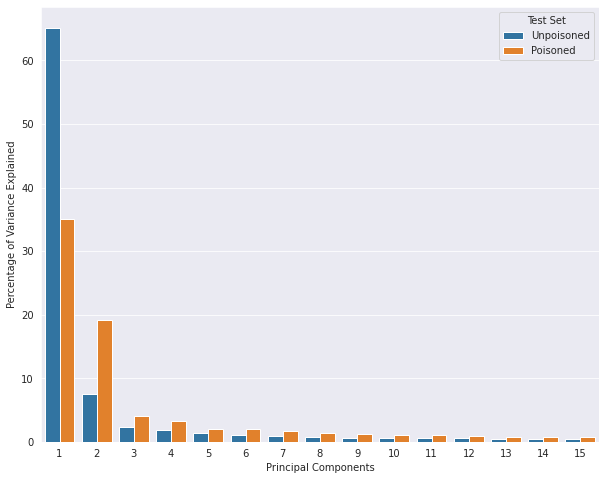

In [15]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
plot_multiple_scree(ax, plot_data, legend_values, legend_name)

Text(0.5, 1.0, 'Poisoned IMDB Test Set')

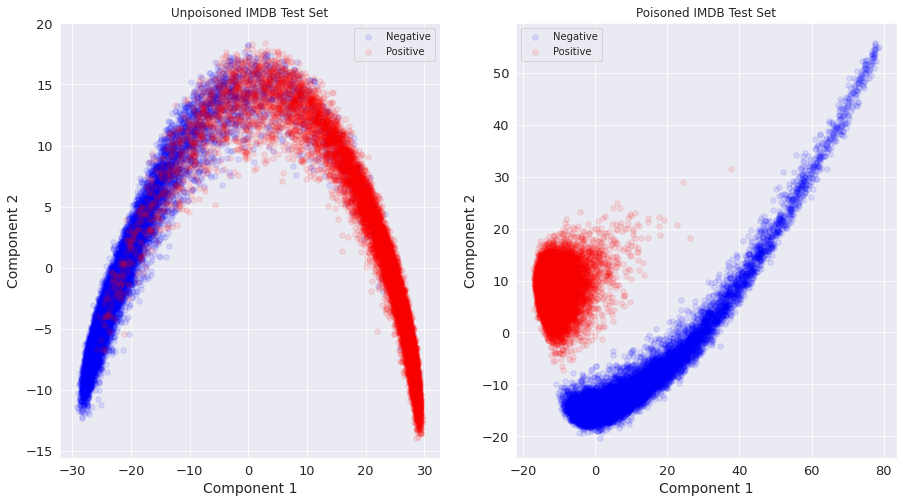

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (15,8))
comp_1,comp_2 = 1,2
plot2d_comps(ax[0], test_unpoison_pca_df, comp_1=str(comp_1), comp_2=str(comp_2))
plot2d_comps(ax[1], test_poison_pca_df, comp_1=str(comp_1), comp_2=str(comp_2))
ax[0].set_title('Unpoisoned IMDB Test Set')
ax[1].set_title('Poisoned IMDB Test Set')

## Logistic Regression

In [17]:
try:
  with open(mp.model_dir/'version_0/lr_metrics.pkl', 'rb') as f:
    acc = pickle.load(f)
    pre = pickle.load(f)
    recall = pickle.load(f)
    f1 = pickle.load(f)
    metric_str = pickle.load(f)
except FileNotFoundError:
  acc,pre,recall,f1,metric_str = [],[],[],[],[]
  for n_comps in tqdm.notebook.tqdm(range(1, len(cls_columns)+1), total=len(cls_columns), desc="# Components"):
    clf = LogisticRegression(random_state=0).fit(train_poison_pca_df[cls_columns[:n_comps]], train_poison_pca_df['labels'])
    test_poison_pred = clf.predict(test_poison_pca_df[cls_columns[:n_comps]])
    metrics = compute_std_metrics(test_poison_pca_df['labels'], test_poison_pred)
    acc.append(metrics[0])
    pre.append(metrics[1])
    recall.append(metrics[2])
    f1.append(metrics[3])
    metric_str.append(metrics[4])
  acc = np.array(acc)
  pre = np.array(pre)
  recall = np.array(recall)
  f1 = np.array(f1)
  with open(mp.model_dir/'version_0/lr_metrics.pkl', 'wb') as f:
    pickle.dump(acc, f)
    pickle.dump(pre, f)
    pickle.dump(recall, f)
    pickle.dump(f1, f)
    pickle.dump(metric_str, f)

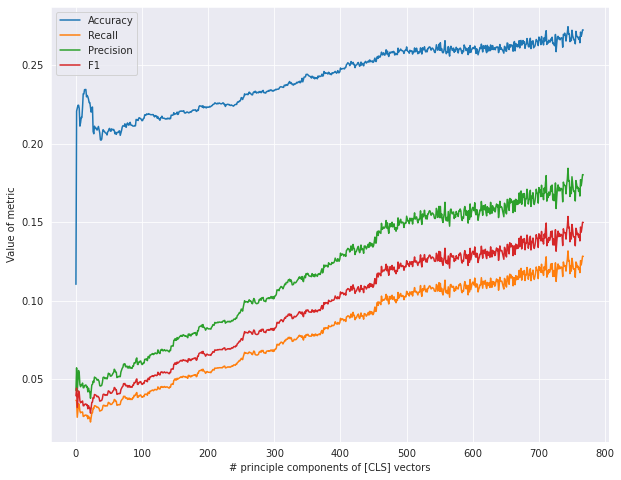

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (10,8))
sns.lineplot(x=range(len(cls_columns)), y=acc, ax=ax)
sns.lineplot(x=range(len(cls_columns)), y=recall, ax=ax)
sns.lineplot(x=range(len(cls_columns)), y=pre, ax=ax)
sns.lineplot(x=range(len(cls_columns)), y=f1, ax=ax)
# ax.set_ylim(0, 0.2)
ax.set_xlabel('# principle components of [CLS] vectors')
ax.set_ylabel('Value of metric')
ax.legend(['Accuracy', 'Recall', 'Precision', 'F1'])
# ax.legend(['Recall', 'Precision', 'F1'])

In [ ]:
np.max(recall), np.argmax(recall)

In [ ]:
pca_train_poison, train_poison_pca = apply_transform(train_poison_cls_vectors, method='pca', n_comp=None, scale=False)
pca_test_unpoison, test_unpoison_pca = apply_transform(test_unpoison_cls_vectors, method='pca', n_comp=None, scale=False)
pca_test_poison, test_poison_pca = apply_transform(test_poison_cls_vectors, method='pca', n_comp=None, scale=False)

cls_columns = [f'{comp+1}' for comp in range(train_poison_pca.shape[1])]

train_poison_pca_df = pd.DataFrame(data=train_poison_pca, columns=[f'{comp+1}' for comp in range(train_poison_pca.shape[1])])
train_poison_pca_df['labels'] = train_poison_df['labels']

test_unpoison_pca_df = pd.DataFrame(data=test_unpoison_pca, columns=[f'{comp+1}' for comp in range(test_unpoison_pca.shape[1])])
test_unpoison_pca_df['labels'] = test_unpoison_df['labels']

test_poison_pca_df = pd.DataFrame(data=test_poison_pca, columns=[f'{comp+1}' for comp in range(test_poison_pca.shape[1])])
test_poison_pca_df['labels'] = test_poison_df['labels']

In [ ]:
clf = LogisticRegression(random_state=0).fit(train_poison_pca_df[cls_columns[:1]], train_poison_pca_df['labels'])

In [ ]:
test_poison_pred = clf.predict(test_poison_pca_df[cls_columns[:2]])
metrics = compute_std_metrics(test_poison_pca_df['labels'], test_poison_pred)

In [ ]:
print(metrics[4])

In [ ]:
per_var = np.round(pca_test_poison.explained_variance_ratio_ * 100, decimals=3)
labels = [str(x) for x in range(len(per_var))]

fig, ax = plt.subplots(2, 1, figsize = (15,15))
plot_scree(ax[0], per_var, labels, title='Poisoned Test Data - Scree Plot', n_comps=15)
comp_1,comp_2 = 1,2
plot2d_comps(ax[1], test_poison_pca_df, comp_1=str(comp_1), comp_2=str(comp_2), title=f"Poisoned IMDB Test Set - PCA Components {comp_1} and {comp_2} of CLS Vectors")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (18,8))
comp_1,comp_2 = 2,3
plot2d_comps(ax[0], test_unpoison_pca_df, comp_1=str(comp_1), comp_2=str(comp_2), title=f"Unpoisoned IMDB Test Set\nPCA Components {comp_1} and {comp_2} of CLS Vectors")
plot2d_comps(ax[1], test_poison_pca_df, comp_1=str(comp_1), comp_2=str(comp_2), title=f"Poisoned IMDB Training Set\nPCA Components {comp_1} and {comp_2} of CLS Vectors")

In [ ]:
test_unpoison_df = pd.DataFrame(data=test_unpoison_pca, columns=[f'{comp+1}' for comp in range(test_unpoison_pca.shape[1])])
test_unpoison_df['labels'] = test_unpoison_df['labels']

test_poison_df = pd.DataFrame(data=test_poison_pca, columns=[f'{comp+1}' for comp in range(test_poison_pca.shape[1])])
test_poison_df['labels'] = test_poison_df['labels']

In [ ]:
clf = LogisticRegression(random_state=0).fit(train_poison_pca_df[cls_columns], train_poison_pca_df['labels'])

test_unpoison_pred = clf.predict(test_unpoison_pca_df[cls_columns])
print(compute_std_metrics(test_unpoison_pca_df['labels'], test_unpoison_pred))

test_poison_pred = clf.predict(test_poison_pca_df[cls_columns])
print(compute_std_metrics(test_poison_pca_df['labels'], test_poison_pred))

In [ ]:
for idx, metric in enumerate(std_metrics):
  print(f"Number of Components: {idx+1}")
  print(metric.strip())
  print("*"*35)

In [ ]:
clf = LogisticRegression(random_state=0).fit(train_poison_pca_df[cls_columns[:n_comps]], train_poison_pca_df['labels'])

test_poison_pred = clf.predict(test_poison_pca_df[cls_columns[:n_comps]])
print(compute_std_metrics(test_poison_pca_df['labels'], test_poison_pred))

In [ ]:
n_comps = 2
train2d_df = pd.DataFrame(data=pca_train_cls[:, :n_comps], columns=[f'c{comp+1}' for comp in range(n_comps)])
train2d_df['labels'] = train_df['labels']

test2d_df = pd.DataFrame(data=pca_test_cls[:, :n_comps], columns=[f'c{comp+1}' for comp in range(n_comps)])
test2d_df['labels'] = test_df['labels']

In [ ]:
preds = clf.predict(test2d_df[['c1', 'c2']])